In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp

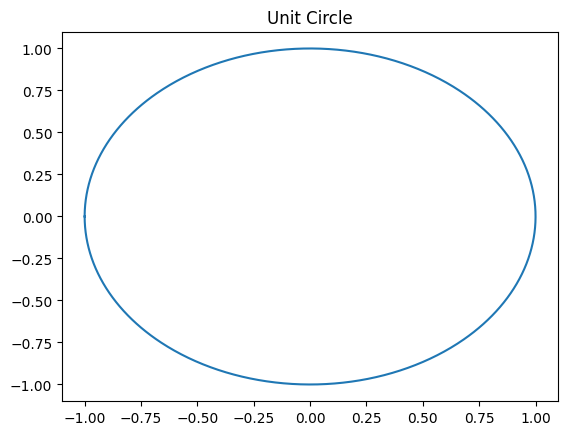

In [19]:
theta = np.linspace(-np.pi, np.pi, num=1000)
x_vals = np.cos(theta)
y_vals = np.sin(theta)

plt.plot(x_vals, y_vals)
plt.title('Unit Circle')
plt.show()

### Exercise

1. Create a Neural Network that accepts two inputs. $(x,y)$. This will be intended to predict the $\theta$ at $tan\theta = \frac{y}{x}$. Make sure that it's guaranteed to output from $[-\pi, \pi]$
2. Formulate a Loss Function using von Mises Distribution as stated in **Section 5.2**
3. Train the Neural Network from (1) using (2)
4. Train the Neural Network from (1) using Loss Function derived using Gaussian (Least Square Loss)
5. Compare the results of (3) and (4)

## Step 1

Create a Neural Network that accepts two inputs. $(x,y)$. This will be intended to predict the $\theta$ at $tan\theta = \frac{y}{x}$. Make sure that it's guaranteed to output from $[-\pi, \pi]$

### Guarantee that the final activation has a Domain of $[-\pi, \pi]$ 

Here we will be using $a[z] = \pi * tanh[z]$

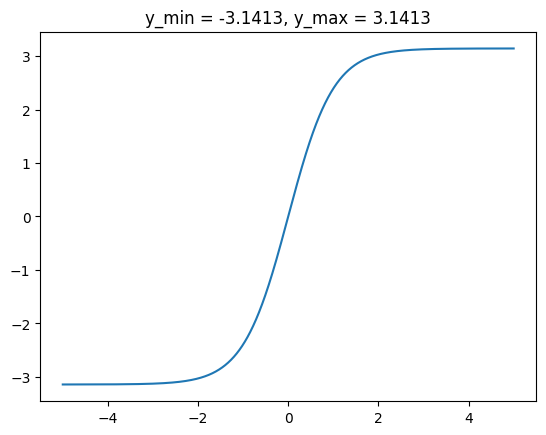

In [18]:
x_max = 5
x_range = jnp.linspace(-x_max, x_max, num=2000)
y_out = jnp.pi * jnp.tanh(x_range)

y_min = float(jnp.min(y_out))
y_max = float(jnp.max(y_out))

y_min = round(y_min, 4)
y_max = round(y_max, 4)

plt.plot(x_range, y_out)
plt.title(f'y_min = {y_min}, y_max = {y_max}')
plt.show()

In [158]:
import jax.numpy as jnp
from jax import grad, jit, vmap, jacobian
from jax import random
import math
from jax.scipy.special import logsumexp
from jax.nn import sigmoid
import jax

# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (m, n)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(network_sizes, scale=1e-2):
  key =  random.PRNGKey(0)
  keys = random.split(key, len(network_sizes))
  return [
     random_layer_params(in_out[0], in_out[1], k, scale) for in_out, k in zip(network_sizes, keys)]

def display_params(params, params_name):
   print(f'{params_name} total num_layers = ', len(params))
   for level, param in enumerate(params, start=1):
      weight_shape = param[0].shape
      bias_shape = param[1].shape
      print(f'({level}) {params_name}_weights.shape = {weight_shape}, {params_name}_bias.shape = {bias_shape}')

In [283]:
def relu(x):
    return jnp.where(x >= 0, x, 0)

def least_squares_loss_func(y_pred,y_target):
    return jnp.sum((y_pred - y_target) ** 2)

def cosine_loss_func(y_pred, y_target):
    return -jnp.sum(jnp.cos(y_target - y_pred))

def linear(W, x):
    return x @ W

def predict(params, X):
    activations = X 
    for w, b in params[:-1]:
        outputs = activations @ w + b
        activations = relu(outputs)
    
    final_w = params[-1][0]
    final_b = params[-1][1]

    logits = activations @ final_w + final_b
    # return jnp.pi * logits
    return jnp.pi * jnp.tanh(logits)



@jit
def loss_von_mises(params, X_train, y_train):
  preds = predict(params, X_train)
  return cosine_loss_func(preds, y_train)

@jit
def loss_least_squares(params, X_train, y_train):
  preds = predict(params, X_train)
  return least_squares_loss_func(preds, y_train)

In [287]:
import numpy as np

def generate_data(num_sample):
  seed = np.random.randint(0, 1024)
  key =  jax.random.PRNGKey(seed)
  key, subkey = jax.random.split(key)
  thetas = jnp.linspace( -jnp.pi, jnp.pi, num=num_sample).reshape(-1, 1)
  X_vals = jnp.cos(thetas)
  Y_vals = jnp.sin(thetas)
  X_train = jnp.hstack([X_vals, Y_vals])
  return X_train, thetas

def update_weights_von_mises(params, X, y, step_size):
  grads = grad(loss_von_mises)(params, X, y)

  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

def update_weights_least_squares(params, X, y, step_size):
  grads = grad(loss_least_squares)(params, X, y)

  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

def train_network_von_mises(params, num_sample, num_epochs, step_size, step_display):
  for curr_epoch in range(1, num_epochs + 1):
    X_train, y_train = generate_data(num_sample)
    params = update_weights_von_mises(params, X_train, y_train, step_size)
    loss = loss_von_mises(params, X_train, y_train)
    if curr_epoch % step_display == 0:
      print(f'[{curr_epoch}/{num_epochs}] Loss: {loss}')

  return params

def train_network_least_squares(params, num_sample, num_epochs, step_size, step_display):
  for curr_epoch in range(1, num_epochs + 1):
    X_train, y_train = generate_data(num_sample)
    params = update_weights_least_squares(params, X_train, y_train, step_size)
    loss = loss_least_squares(params, X_train, y_train)
    if curr_epoch % step_display == 0:
      print(f'[{curr_epoch}/{num_epochs}] Loss: {loss}')

  return params

def generate_sine_data(num_sample):
  seed = np.random.randint(0, 1024)
  key =  jax.random.PRNGKey(seed)
  key, subkey = jax.random.split(key)
  thetas = jnp.linspace( -jnp.pi, jnp.pi, num=num_sample).reshape(-1, 1)
  X_train = jnp.sin(thetas)
  return X_train, thetas

def update_weights_von_mises(params, X, y, step_size):
  grads = grad(loss_von_mises)(params, X, y)

  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

def train_network_von_mises_sine(params, num_sample, num_epochs, step_size, step_display):
  for curr_epoch in range(1, num_epochs + 1):
    X_train, y_train = generate_sine_data(num_sample)
    params = update_weights_von_mises(params, X_train, y_train, step_size)
    loss = loss_von_mises(params, X_train, y_train)
    if curr_epoch % step_display == 0:
      print(f'[{curr_epoch}/{num_epochs}] Loss: {loss}')

  return params

def train_network_least_squares_sine(params, num_sample, num_epochs, step_size, step_display):
  for curr_epoch in range(1, num_epochs + 1):
    X_train, y_train = generate_sine_data(num_sample)
    params = update_weights_least_squares(params, X_train, y_train, step_size)
    loss = loss_least_squares(params, X_train, y_train)
    if curr_epoch % step_display == 0:
      print(f'[{curr_epoch}/{num_epochs}] Loss: {loss}')

  return params

### First Trial
- Predicting Angle of Sine

[1000/10000] Loss: -621.70361328125
[2000/10000] Loss: -622.0106201171875
[3000/10000] Loss: -622.0672607421875
[4000/10000] Loss: -622.1002197265625
[5000/10000] Loss: -622.1195068359375
[6000/10000] Loss: -622.1397094726562
[7000/10000] Loss: -622.15966796875
[8000/10000] Loss: -622.187744140625
[9000/10000] Loss: -622.2321166992188
[10000/10000] Loss: -622.297119140625
[1000/10000] Loss: 13481.88671875
[2000/10000] Loss: 13481.88671875
[3000/10000] Loss: 13481.88671875
[4000/10000] Loss: 13481.88671875
[5000/10000] Loss: 13481.88671875
[6000/10000] Loss: 13481.88671875
[7000/10000] Loss: 13481.88671875
[8000/10000] Loss: 13481.88671875
[9000/10000] Loss: 13481.88671875
[10000/10000] Loss: 13481.88671875


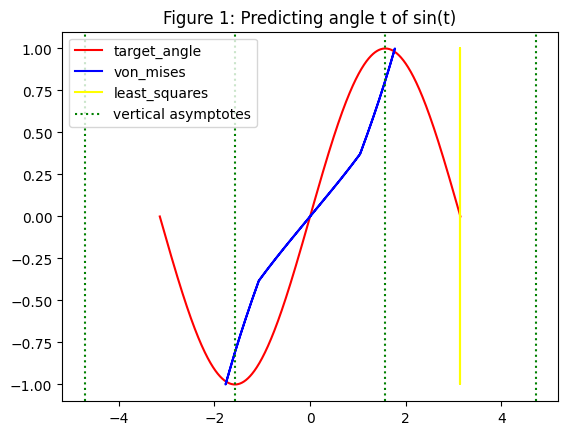

In [297]:
num_hidden = 128
num_samples = 1024
network_sizes_sine = [
    (1, num_hidden),
    (num_hidden, 1)
]

step_size_von_mises = 1e-5
step_size_least_squares = 0.005
num_epochs = 10000
current_round = 0
step_display = 1000
X_test_sine, y_test_sine = generate_sine_data(num_samples)

params_sine_vm = init_network_params(network_sizes_sine)
params_sine_ls = init_network_params(network_sizes_sine)

params_sine_vm = train_network_von_mises_sine(params_sine_vm, num_samples, num_epochs, step_size_von_mises, step_display)
params_sine_ls = train_network_least_squares_sine(params_sine_ls, num_samples, num_epochs, step_size_least_squares, step_display)

y_pred_sine_vm = predict(params_sine_vm, X_test_sine)
y_pred_sine_ls = predict(params_sine_ls, X_test_sine)

plt.plot(y_test_sine.reshape(-1), X_test_sine.reshape(-1), color='red', label='target_angle')
plt.plot(y_pred_sine_vm.reshape(-1), X_test_sine.reshape(-1), color='blue', label='von_mises')
plt.plot(y_pred_sine_ls.reshape(-1), X_test_sine.reshape(-1), color='yellow', label='least_squares')
plt.axvline(- 3 * np.pi / 2, linestyle='dotted', color='green')
plt.axvline(- 1 * np.pi / 2, linestyle='dotted', color='green')
plt.axvline( 1 * np.pi / 2, linestyle='dotted', color='green')
plt.axvline( 3 * np.pi / 2, linestyle='dotted', color='green', label='vertical asymptotes')
plt.legend()
plt.title('Figure 1: Predicting angle t of sin(t)')
plt.show()


# plt.plot(y_train.reshape(-1), X_train[:,1].reshape(-1), color='red', label='actual angle')
# plt.plot(y_pred.reshape(-1), X_train[:,1].reshape(-1), color='blue', label='predicted angle')
# plt.legend()
# plt.show()

### Second Trial
- Predicting the Angle of Unit Circle

In [280]:
step_sizes = [1e-2, 5e-2, 1e-3, 5e-4 ,1e-4, 5e-5, 1e-5, 5e-6, 1e-6]
num_hidden = 256
num_samples = 1024
network_sizes = [
    (2, num_hidden),
    (num_hidden, 1)
]


num_epochs = 1000
current_round = 0
step_display = 1000

X_test, y_test = generate_data(num_samples)

prediction_data = {
    step_size: []
    for step_size in step_sizes
}

total_steps = len(step_sizes)

for count, step_size in enumerate(step_sizes,start=1):
    
    print(f'[{count}/{total_steps}] For step_size = {step_size}')
    params_vm = init_network_params(network_sizes)
    params_ls = init_network_params(network_sizes)

    params_vm = train_network_von_mises(params_vm, num_samples, num_epochs, step_size, step_display)
    params_ls = train_network_least_squares(params_ls, num_samples, num_epochs, step_size, step_display)

    y_pred_vm = predict(params_vm, X_test).reshape(-1)
    y_pred_ls = predict(params_ls, X_test).reshape(-1)

    prediction_data[step_size] = { 'y_pred_vm' : y_pred_vm, 'y_pred_ls' : y_pred_ls }        



[1/9] For step_size = 0.01
[1000/1000] Loss: -0.9996250867843628
[1000/1000] Loss: 0.40592148900032043
[2/9] For step_size = 0.05
[1000/1000] Loss: -1.0000280141830444
[1000/1000] Loss: 0.20572417974472046
[3/9] For step_size = 0.001
[1000/1000] Loss: -362.929443359375
[1000/1000] Loss: 0.9902106523513794
[4/9] For step_size = 0.0005
[1000/1000] Loss: -701.142333984375
[1000/1000] Loss: 1.5791213512420654
[5/9] For step_size = 0.0001
[1000/1000] Loss: -945.30322265625
[1000/1000] Loss: 3.1939914226531982
[6/9] For step_size = 5e-05
[1000/1000] Loss: -916.7898559570312
[1000/1000] Loss: 3.2510859966278076
[7/9] For step_size = 1e-05
[1000/1000] Loss: -806.0595703125
[1000/1000] Loss: 3.2893435955047607
[8/9] For step_size = 5e-06
[1000/1000] Loss: -749.5234375
[1000/1000] Loss: 3.29409122467041
[9/9] For step_size = 1e-06
[1000/1000] Loss: -132.57321166992188
[1000/1000] Loss: 3.2979226112365723


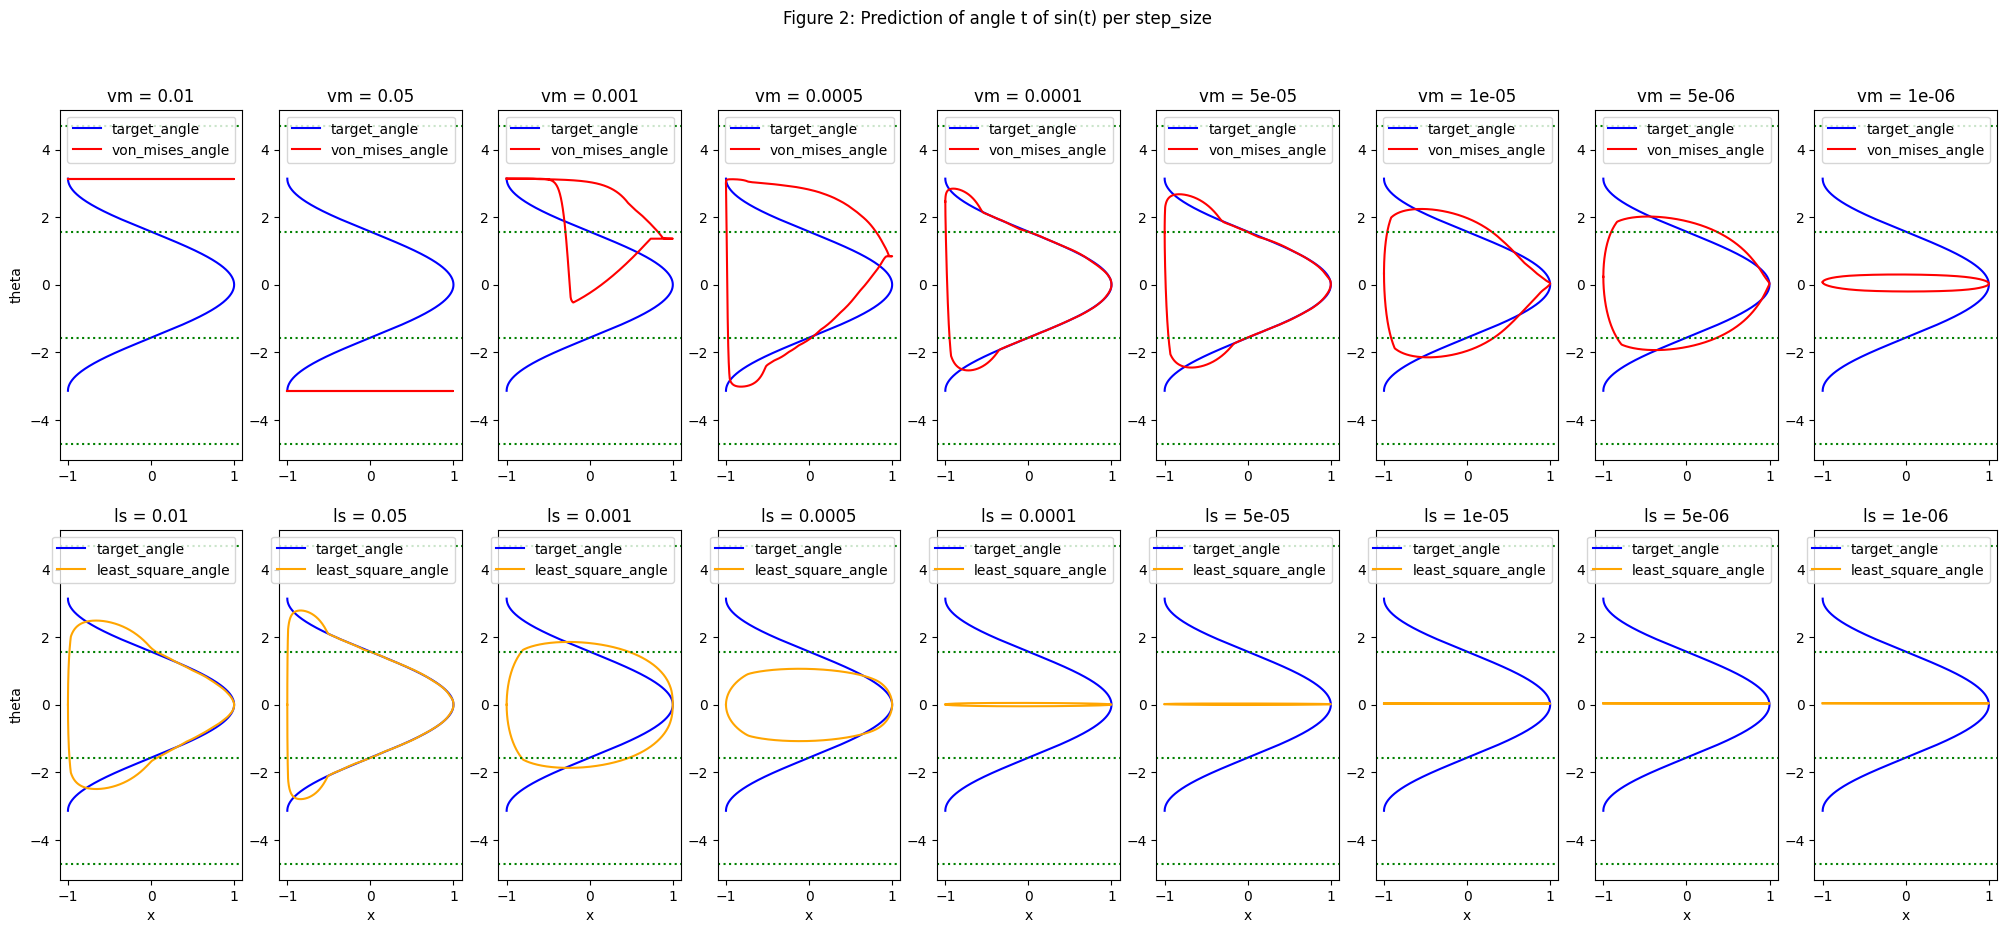

In [298]:
counter = 0

figsize = (25,10)
fig, axs = plt.subplots(2, len(step_sizes), figsize=figsize)

for step_size, preds in prediction_data.items():
    axs[0, counter].plot(X_test[:,0].reshape(-1), y_test.reshape(-1), color='blue', label='target_angle')
    axs[0, counter].plot(X_test[:,0].reshape(-1), preds['y_pred_vm'], color='red', label='von_mises_angle')
    axs[0, counter].axhline(- 3 * np.pi / 2, linestyle='dotted', color='green')
    axs[0, counter].axhline(- 1 * np.pi / 2, linestyle='dotted', color='green')
    axs[0, counter].axhline( 1 * np.pi / 2, linestyle='dotted', color='green')
    axs[0, counter].axhline( 3 * np.pi / 2, linestyle='dotted', color='green')
    axs[0, counter].legend()

    axs[1, counter].plot(X_test[:,0].reshape(-1), y_test.reshape(-1), color='blue', label='target_angle')
    axs[1, counter].plot(X_test[:,0].reshape(-1), preds['y_pred_ls'], color='orange', label='least_square_angle')
    axs[1, counter].axhline(- 3 * np.pi / 2, linestyle='dotted', color='green')
    axs[1, counter].axhline(- 1 * np.pi / 2, linestyle='dotted', color='green')
    axs[1, counter].axhline( 1 * np.pi / 2, linestyle='dotted', color='green')
    axs[1, counter].axhline( 3 * np.pi / 2, linestyle='dotted', color='green' )
    axs[1, counter].legend()
    
    if counter == 0:
        axs[0, counter].set_ylabel('theta')
        axs[1, counter].set_ylabel('theta')

    axs[1, counter].set_xlabel('x')
    
    axs[0, counter].set_title(f'vm = {step_size}')
    axs[1, counter].set_title(f'ls = {step_size}')
    
    counter += 1

fig.suptitle('Figure 2: Prediction of angle t of sin(t) per step_size')
plt.show()


### Observations
- Our von mises loss works well but unlike least squares, it works on smaller learning rates.

### Conclusion
- By inspection of Figure 1 and Figure 2, it's clear that von Mises works better in angular prediction. But there are certain learning rates where least-squares works.

### Lesson Learned
- If it doesn't work on Overfitted training set, there's something wrong with your code.